In [1]:
try:
 import art
except ModuleNotFoundError:
 !pip install adversarial-robustness-toolbox # module doesn't exist, deal with it.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 8.3 MB/s 
     |████████████████████████████████| 3.3 MB 26.0 MB/s 
     |████████████████████████████████| 34.5 MB 11 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [2]:
try:
 import cma
except ModuleNotFoundError:
 !pip install cma # module doesn't exist, deal with it.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 249 kB 8.5 MB/s 


In [3]:
! pip show adversarial-robustness-toolbox

Name: adversarial-robustness-toolbox
Version: 1.11.0
Summary: Toolbox for adversarial machine learning.
Home-page: https://github.com/Trusted-AI/adversarial-robustness-toolbox
Author: Irina Nicolae
Author-email: irinutza.n@gmail.com
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: setuptools, tqdm, numba, six, scikit-learn, numpy, scipy
Required-by: 


# 1. Config the Environment

In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import sys


print(f'python version: {sys.version}')
print(f'tensorflow version: {tf.__version__}')
print(f'keras version: {keras.__version__}')
print(f'numpy version: {np.__version__}')

python version: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
tensorflow version: 2.8.2
keras version: 2.8.0
numpy version: 1.21.6


In [5]:
from art.attacks.evasion.pixel_threshold import PixelAttack
from art.estimators.classification import TensorFlowV2Classifier

In [6]:
# Load data and normalize
from art.utils import load_cifar10
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
               'horse', 'ship', 'truck']

In [7]:
# Select 10 and 100 random simple from Test set to test the algorithm
random_sample_10 = np.random.randint(low = 0, high = 10000, size = 10)
random_sample_10 = np.sort(random_sample_10).tolist()

random_sample_100 = np.random.randint(low = 0, high = 10000, size = 100)
random_sample_100 = np.sort(random_sample_100).tolist()

x_test_10 = x_test[random_sample_10,:,:,:]
x_test_100 = x_test[random_sample_100,:,:,:]

y_test_10 = y_test[random_sample_10, :]
y_test_100 = y_test[random_sample_100, :]


# 2. Test different model

## 2.1 ResNet50 model attack

### 2.1 Config ResNet50 model

In [8]:
!wget 'https://gitlab.act.reading.ac.uk/vo836354/msc_final_project_model/-/raw/main/saved_model/ResNet_TransferLearning/HDF5/ResNet_TransferLearning.h5?inline=false' -O /content/ResNet.h5

--2022-07-13 21:04:43--  https://gitlab.act.reading.ac.uk/vo836354/msc_final_project_model/-/raw/main/saved_model/ResNet_TransferLearning/HDF5/ResNet_TransferLearning.h5?inline=false
Resolving gitlab.act.reading.ac.uk (gitlab.act.reading.ac.uk)... 134.225.116.8
Connecting to gitlab.act.reading.ac.uk (gitlab.act.reading.ac.uk)|134.225.116.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94932256 (91M) [application/octet-stream]
Saving to: ‘/content/ResNet.h5’

/content/ResNet.h5  100%[===================>]  90.53M  19.5MB/s    in 5.7s    

2022-07-13 21:04:51 (15.8 MB/s) - ‘/content/ResNet.h5’ saved [94932256/94932256]



In [9]:
model = tf.keras.models.load_model('/content/ResNet.h5', compile=True)

In [10]:
# Create the ART classifier, pass the model to the ART classifier

classifier = TensorFlowV2Classifier(model=model, nb_classes=10, input_shape=(32, 32, 3), clip_values=(min_, max_))
#, clip_values=(min_, max_)

In [11]:
# Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 41.9%


### 2.2 Pixel Attack


#### 2.2.1 Test Untarget Attack

In [12]:
attack = PixelAttack(classifier, th=1, es=1, max_iter=20, targeted=False, verbose=False)

##### 2.2.1.1 Use 10 samples for showing difference and effects

In [13]:
x_test_adv = attack.generate(x_test_10)

In [14]:
x_test_adv = np.clip(x_test_adv, 0, 1)

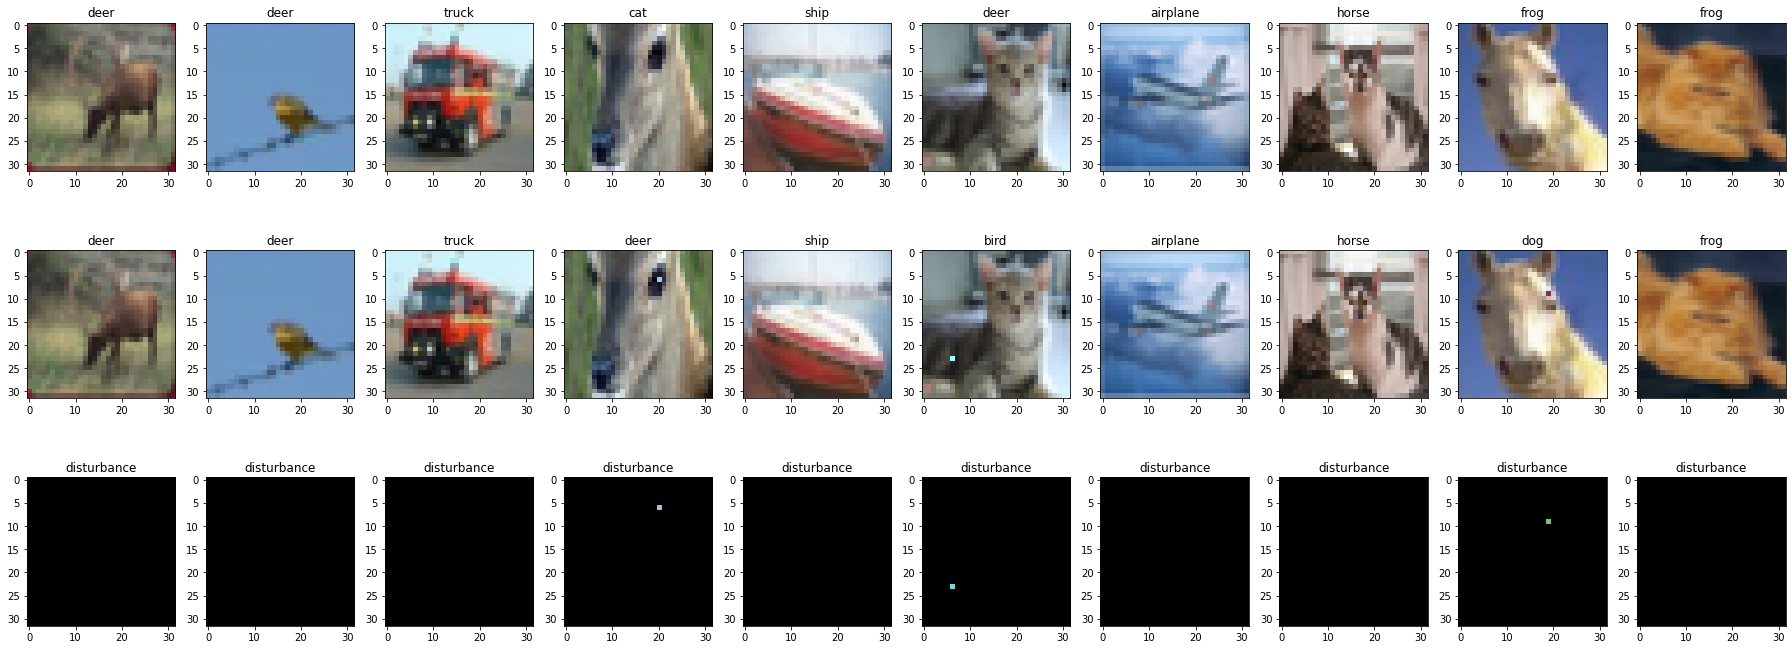

In [15]:
fig, axs = plt.subplots(3, len(x_test_adv), figsize = (25, 10))

for i in range(len(x_test_adv)):
  axs[0, i].imshow(x_test_10[i])
  axs[1, i].imshow(x_test_adv[i])
  axs[2, i].imshow(np.abs(x_test_10[i] -  x_test_adv[i]))
  axs[0, i].set_title(label_names[np.argmax(classifier.predict(x_test_10[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[1, i].set_title(label_names[np.argmax(classifier.predict(x_test_adv[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[2, i].set_title('disturbance')
  fig.tight_layout()

##### 2.2.1.2 Test the effect of the attack with 100 random examples

In [16]:
x_test_adv = attack.generate(x=x_test_100)

In [17]:
# Evaluate the ART classifier on benign test examples

predictions_adv = classifier.predict(x_test_adv)
predictions_ori = classifier.predict(x_test_100)

accuracy_adv = np.sum(np.argmax(predictions_adv, axis=1) == np.argmax(y_test_100, axis=1)) / len(y_test_100)
accuracy_ori = np.sum(np.argmax(predictions_ori, axis=1) == np.argmax(y_test_100, axis=1)) / len(y_test_100)

print(f'Total use \033[31m{len(x_test_adv)}\033[0m examples for testing')
print(f"Accuracy on before the attack: {accuracy_ori * 100}%, Accuracy on after the attack: {accuracy_adv * 100}%")

Total use 100 examples for testing
Accuracy on before the attack: 44.0, Accuracy on after the attack: 37.0


##### 2.2.1.3 Test different Parameters

In [18]:
print(f'Total use \033[31m{len(x_test_adv)}\033[0m examples for testing')

for th in [None, 128]:
  for es in [0, 1]:
    attack = PixelAttack(classifier, th=th, es=es, max_iter=20, targeted=False, verbose=False)
    x_test_adv = attack.generate(x_test_100)

    predictions_adv = classifier.predict(x_test_adv)
    predictions_ori = classifier.predict(x_test_100)

    accuracy_adv = np.sum(np.argmax(predictions_adv, axis=1) == np.argmax(y_test_100, axis=1)) / len(y_test_100)
    accuracy_ori = np.sum(np.argmax(predictions_ori, axis=1) == np.argmax(y_test_100, axis=1)) / len(y_test_100)

    print(f'Total use \033[31m{len(x_test_adv)}\033[0m examples for testing')
    print(f"Accuracy on before the attack: {accuracy_ori * 100}%, Accuracy on after the attack: {accuracy_adv * 100}%")

Total use 100 examples for testing
Total use 100 examples for testing
Accuracy on before the attack: 44.0, Accuracy on after the attack: 20.0
Total use 100 examples for testing
Accuracy on before the attack: 44.0, Accuracy on after the attack: 16.0
Total use 100 examples for testing
Accuracy on before the attack: 44.0, Accuracy on after the attack: 24.0
Total use 100 examples for testing
Accuracy on before the attack: 44.0, Accuracy on after the attack: 15.0


#### 2.2.2 Test target Attack

In [19]:
def generate_random_target(ori_target, classes_num):
  class_y_test = np.argmax(ori_target, axis=1)
  nb_classes = np.unique(class_y_test).shape[0]
  targets = np.random.randint(nb_classes, size=len(ori_target))
  for i in range(len(ori_target)):
      if class_y_test[i] == targets[i]:
        tmp = np.random.randint(0, 9)
        while tmp == class_y_test[i]:
          tmp = np.random.randint(0, 9)
        targets[i] = tmp

  targets = tf.one_hot(targets, classes_num)

  return targets

##### 2.2.2.1 Use 10 samples for showing difference and effects

In [20]:
targets = generate_random_target(y_test_10, 10)

In [21]:
attack = PixelAttack(classifier, th=150, es=1, max_iter=20, targeted=True, verbose=False)

In [22]:
x_test_adv = attack.generate(x_test_10, targets)

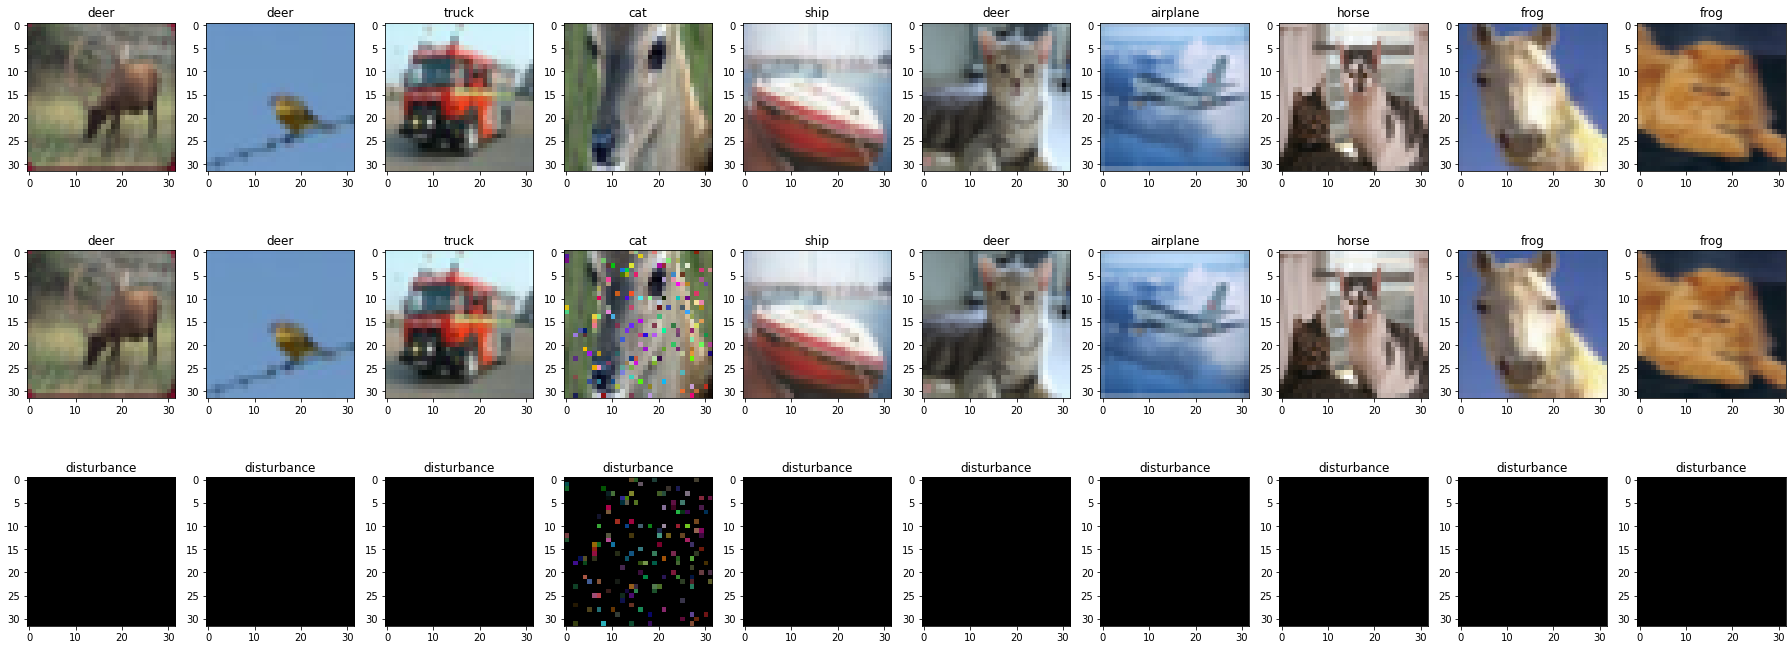

In [23]:
fig, axs = plt.subplots(3, len(x_test_adv), figsize = (25, 10))

for i in range(len(x_test_adv)):
  axs[0, i].imshow(x_test_10[i])
  axs[1, i].imshow(x_test_adv[i])
  axs[2, i].imshow(np.abs(x_test_10[i] -  x_test_adv[i]))
  axs[0, i].set_title(label_names[np.argmax(classifier.predict(x_test_10[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[1, i].set_title(label_names[np.argmax(classifier.predict(x_test_adv[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[2, i].set_title('disturbance')
  fig.tight_layout()

##### 2.2.2.2 Use 100 samples for showing difference and effects

In [24]:
targets = generate_random_target(y_test_100, 10)

In [25]:
x_test_adv = attack.generate(x_test_100, y_test_100)

In [26]:
# Evaluate the ART classifier on benign test examples

predictions_adv = classifier.predict(x_test_adv)
predictions_ori = classifier.predict(x_test_100)

accuracy_adv = np.sum(np.argmax(predictions_adv, axis=1) == np.argmax(y_test_100, axis=1)) / len(y_test_100)
accuracy_ori = np.sum(np.argmax(predictions_ori, axis=1) == np.argmax(y_test_100, axis=1)) / len(y_test_100)

print(f'Total use \033[31m{len(x_test_adv)}\033[0m examples for testing')
print(f"Accuracy on before the attack: {accuracy_ori * 100}%, Accuracy on after the attack: {accuracy_adv * 100}%")

Total use 100 examples for testing
Accuracy on before the attack: 44.0, Accuracy on after the attack: 64.0


##### 2.2.1.3 Test different Parameters

In [27]:
print(f'Total use \033[31m{len(x_test_adv)}\033[0m examples for testing')

for th in [None, 128]:
  for es in [0, 1]:
    attack = PixelAttack(classifier, th=th, es=es, max_iter=20, targeted=True, verbose=False)

    targets = generate_random_target(y_test_100, 10)
    x_test_adv = attack.generate(x_test_100, y_test_100)

    predictions_adv = classifier.predict(x_test_adv)
    predictions_ori = classifier.predict(x_test_100)

    accuracy_adv = np.sum(np.argmax(predictions_adv, axis=1) == np.argmax(y_test_100, axis=1)) / len(y_test_100)
    accuracy_ori = np.sum(np.argmax(predictions_ori, axis=1) == np.argmax(y_test_100, axis=1)) / len(y_test_100)

    print(f'Total use \033[31m{len(x_test_adv)}\033[0m examples for testing')
    print(f"Accuracy on before the attack: {accuracy_ori * 100}%, Accuracy on after the attack: {accuracy_adv * 100}%")

Total use 100 examples for testing
Total use 100 examples for testing
Accuracy on before the attack: 44.0, Accuracy on after the attack: 64.0
Total use 100 examples for testing
Accuracy on before the attack: 44.0, Accuracy on after the attack: 70.0
Total use 100 examples for testing
Accuracy on before the attack: 44.0, Accuracy on after the attack: 61.0
Total use 100 examples for testing
Accuracy on before the attack: 44.0, Accuracy on after the attack: 63.0
